# Transformers for Battery States Estimation

**Author:** Ahmed Abdulmaksoud
**Email** abdula96@mcmaster.ca

---

## Introduction

This notebook demonstrates the use of Transformer models for estimating the state of charge (SoC) in batteries. The Transformer architecture, originally designed for natural language processing tasks, has shown great promise in time-series forecasting and regression tasks due to its ability to capture long-range dependencies.

---

## Dataset

The dataset used in this notebook is derived from battery charge and discharge cycles. It includes various features such as voltage, current, and temperature readings at different time steps. The dataset is split into training, validation, and test sets to evaluate the performance of the model.

---

## Algorithms

### Transformer Model

The Transformer model is an advanced neural network architecture that relies on self-attention mechanisms to process input sequences. It consists of an encoder and a decoder, each composed of multiple layers of self-attention and feedforward neural networks.

#### Encoder

The encoder processes the input sequence and generates a set of attention-based representations. Each encoder layer consists of a multi-head self-attention mechanism followed by a feedforward neural network.

#### Decoder

The decoder takes the encoder's output and generates the final prediction. Similar to the encoder, each decoder layer consists of a multi-head self-attention mechanism and a feedforward neural network. Additionally, the decoder uses masked self-attention to ensure that predictions for a given time step depend only on previous time steps.

### Training and Evaluation

The model is trained using the Mean Squared Error (MSE) loss function, which measures the average squared difference between the predicted and actual SoC values. The Adam optimizer is used to update the model's parameters. Early stopping and learning rate scheduling are employed to prevent overfitting and improve convergence.

---

Let's dive into the implementation!

In [ ]:
# UNCOMMENT AND RUN IF YOU NEED TO INSTALL PACKAGES
# ! pip install -q torch torchvision numpy pandas matplotlib tensorboard optuna

In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch

from torch import nn

In [3]:
from data_providers.LGDataset import SequentialLGDataset, get_dataloader

## Data Preparation

A sequential dataset is created using the sliding window technique. This technique involves sliding a window of length `s` (representing your sequence length) to predict the next State of Charge (SoC). The diagram below illustrates the sliding window used in `data_providers/LGDataset.py`.

![image](./imgs/slidingwindow.png)


In [4]:
train_data = SequentialLGDataset(
    path='datasets/train.csv',
    sequence_length=64,
)

valid_data = SequentialLGDataset(
    path='datasets/valid.csv',
    sequence_length=64,
)

BATCH_SIZE = 64

trainloader = get_dataloader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validloader = get_dataloader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
from typing import Any
import torch.nn.functional as F

class Embedding(nn.Module):
    def __init__(self, input_size:int, output_size:int)->None:
        """
        This class is used to create an embedding layer between the input and the output size

        Parameters
        ----------
        input_size: int
            The size of the input
        output_size: int
            The size of the output
        """
        super(Embedding, self).__init__()
        self.embedding = nn.Linear(input_size, output_size)  # embedding between the input and the output size

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """
        This function is used to pass the input through the embedding layer

        Parameters
        ----------
        x: torch.Tensor
            The input tensor

        Returns
        -------
        torch.Tensor
            The output tensor
        """
        return self.embedding(x)

## Transformer for SoC Estimation
CHANGE THIS INTO ONLY TWO TOWER
![image](./imgs/transformer_for_soc.png)

- The following code implements the Transformer architecture in the previous photo. Note how pytorch abstracts the implementation of the encoder and the decoder.
- Note that we're <strong>NOT USING THE 1D CNN </strong> at the end

In [6]:

class Transformer(nn.Module):
    def __init__(
        self, 
        input_size:int,
        embed_size:int,
        hidden_size:int,
        e_num_layers:int,
        d_num_layer:int, 
        num_heads:int,
        output_size:int,
        dropout:float
        )->None:
        '''
        This class is used to create a transformer model for the prediction of the SoC

        Parameters
        ----------
        input_size: int
            The size of the input
        embed_size: int
            The size of the embedding
        hidden_size: int
            The size of the hidden layer
        e_num_layers: int
            The number of encoder layers
        d_num_layer: int
            The number of decoder layers
        num_heads: int
            The number of attention heads
        output_size: int
            The size of the output
        dropout: float
            The dropout rate

        '''
        super(Transformer, self).__init__()

        # embedding
        self.in_embedding = Embedding(input_size, embed_size)
        self.out_embedding = Embedding(input_size, embed_size)

        # encoders
        self.current_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_size, # set the embedding size of the input
                nhead=num_heads,   # set the number of attention heads
                dim_feedforward=hidden_size, # set the dimension of the inner feedforward network
                activation='gelu', # set the activation function of the inner feedforward network
                dropout=dropout, # set the dropout rate of the encoder
                batch_first=True # set the batch dimension to be the first dimension, returns the output in the shape of (batch_size, seq_len, embed_size)
            ),
            num_layers=e_num_layers # number of encoder layers
        )
        self.voltage_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_size, # set the embedding size of the input
                nhead=num_heads,  # set the number of attention heads
                dim_feedforward=hidden_size, # set the dimension of the inner feedforward network
                activation='gelu', # set the activation function of the inner feedforward network
                dropout=dropout, # set the dropout rate of the encoder
                batch_first=True # set the batch dimension to be the first dimension, returns the output in the shape of (batch_size, seq_len, embed_size)
            ),
            num_layers=e_num_layers # number of encoder layers
        )

        # decoder
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=embed_size*2, # set the embedding size of the output (concatenation of current and voltage embeddings)
                nhead=num_heads, # set the number of attention heads
                dim_feedforward=hidden_size, # set the dimension of the inner feedforward network
                dropout=dropout, # set the dropout rate of the decoder
                batch_first=True # set the batch dimension to be the first dimension, returns the output in the shape of (batch_size, seq_len, embed_size)
            ),
            num_layers=d_num_layer # number of decoder layers
        )

        # output layer
        self.output_layer = nn.Linear(embed_size*2, output_size) # set the output size to 1 to predict the SoC


    def forward(
        self, 
        current_temp:torch.Tensor,
        voltage_temp:torch.Tensor,
        dec_current_temp:torch.Tensor,
        dec_voltage_temp:torch.Tensor
        )->torch.Tensor:
        '''Forward pass of the transformer model
        
        Parameters
        ----------
        current_temp: torch.Tensor
            The current temperature tensor
        voltage_temp: torch.Tensor
            The voltage temperature tensor
        dec_current_temp: torch.Tensor
            The current temperature tensor for the decoder
        dec_voltage_temp: torch.Tensor
            The voltage temperature tensor for the decoder

        Returns
        -------
        torch.Tensor
            The output tensor
        '''
        # encoder
        current_temp = self.in_embedding(current_temp) # (batch_size, seq_len, embed_size)
        voltage_temp = self.in_embedding(voltage_temp) # (batch_size, seq_len, embed_size)
        current_temp = self.current_encoder(current_temp) # (batch_size, seq_len, embed_size)
        voltage_temp = self.voltage_encoder(voltage_temp) # (batch_size, seq_len, embed_size)

        # decoder
        mask = torch.triu(torch.ones(current_temp.size(1), current_temp.size(1)), diagonal=1).bool().to(current_temp.device)
        cat_context = torch.cat((current_temp, voltage_temp), dim=2) # (seq_len, batch_size, 2*input_size)
        dec_current_temp = self.out_embedding(dec_current_temp) # (batch_size, seq_len, embed_size)
        dec_voltage_temp = self.out_embedding(dec_voltage_temp) # (batch_size, seq_len, embed_size)
        cat_dec_context = torch.cat((dec_current_temp, dec_voltage_temp), dim=2) # (batch_size, seq_len, 2*input_size)
        output = self.decoder(cat_dec_context, cat_context, tgt_mask=mask) # (batch_size, seq_len, 2*input_size)

        return self.output_layer(output) # (batch_size, seq_len, 1)

    def training_step(
        self, 
        current_temp:torch.Tensor, 
        voltage_temp:torch.Tensor, 
        dec_current_temp:torch.Tensor, 
        dec_voltage_temp:torch.Tensor, 
        target:torch.Tensor, 
        optimizer:torch.optim.Optimizer
        )->float:
        '''Training step of the transformer model

        Parameters
        ----------
        current_temp: torch.Tensor
            The current temperature tensor
        voltage_temp: torch.Tensor
            The voltage temperature tensor
        dec_current_temp: torch.Tensor
            The current temperature tensor for the decoder
        dec_voltage_temp: torch.Tensor
            The voltage temperature tensor for the decoder
        target: torch.Tensor
            The target tensor
        optimizer: torch.optim.Optimizer
            The optimizer

        Returns
        -------
        float
            The loss value
        '''
        # transfer data to device (either CPU or GPU if available)
        device = next(self.parameters()).device

        current_temp = current_temp.to(device)
        voltage_temp = voltage_temp.to(device)
        dec_current_temp = dec_current_temp.to(device)
        dec_voltage_temp = dec_voltage_temp.to(device)
        target = target.to(device)

        # forward and backward passes
        output = self(current_temp, voltage_temp, dec_current_temp, dec_voltage_temp)
        loss = F.mse_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def validation_step(
        self,
        current_temp:torch.Tensor, 
        voltage_temp:torch.Tensor, 
        dec_current_temp:torch.Tensor, 
        dec_voltage_temp:torch.Tensor, 
        target:torch.Tensor
        )->float:
        '''Validation step of the transformer model

        Parameters
        ----------
        current_temp: torch.Tensor
            The current temperature tensor
        voltage_temp: torch.Tensor
            The voltage temperature tensor
        dec_current_temp: torch.Tensor
            The current temperature tensor for the decoder
        dec_voltage_temp: torch.Tensor
            The voltage temperature tensor for the decoder

        Returns
        -------
        float
            The loss value
        '''
        # transfer data to device
        device = next(self.parameters()).device
        current_temp = current_temp.to(device)
        voltage_temp = voltage_temp.to(device)
        dec_current_temp = dec_current_temp.to(device)
        dec_voltage_temp = dec_voltage_temp.to(device)
        target = target.to(device)

        # forward pass
        with torch.no_grad():
            output = self(current_temp, voltage_temp, dec_current_temp, dec_voltage_temp)
            loss = F.mse_loss(output, target)

        return loss.item()

In [7]:
from IPython.display import clear_output

model = Transformer(
    input_size=2,
    embed_size=64,
    hidden_size=2048,
    e_num_layers=2,
    d_num_layer=2,
    num_heads=1,
    output_size=1,
    dropout=0.1
);

c:\Users\abdula96\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
# caluclate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,443,777 trainable parameters


In [6]:
# sanity check for our model
volt, current, dec_volt, dec_current, target = next(iter(trainloader))

output = model(current, volt, dec_current, dec_volt)
print(output.shape, target.shape)

torch.Size([64, 64, 1]) torch.Size([64, 64, 1])


### Determine Hyperparameters

- Optuna is a good library to perform hyperparameter tuning on your behalf
- It trains the model and uses optimization-based approaches to update the hyperparameters of the model in the direction of the loss improvement

In [8]:
# use optuna to tune the hyperparameters
import optuna

def objective(trial):
    """
    Objective function for hyperparameter optimization using Optuna.

    This function defines a Transformer model and trains it using the provided
    hyperparameters suggested by the Optuna trial. The model is trained for a 
    fixed number of epochs, and the validation loss is reported to Optuna for 
    pruning and optimization.

    Parameters
    ----------
    trial : optuna.trial.Trial
        A trial object that suggests hyperparameters.
    Returns
    -------
    float
        The mean validation loss after training.
        
    Raises
    ------
    optuna.TrialPruned
        If the trial should be pruned based on the validation loss.
    """
    model = Transformer(
        input_size=2,
        hidden_size=trial.suggest_int('hidden_size', 512, 4096),
        e_num_layers=trial.suggest_int('e_num_layers', 1, 4),
        d_num_layer=trial.suggest_int('d_num_layer', 1, 4),
        num_heads=trial.suggest_int('num_heads', 1, 2),
        output_size=1,
        dropout=trial.suggest_float('dropout', 0.1, 0.2)
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-5, 1e-3))

    for epoch in range(10):
        model.train()
        # only train for 5 iterations
        itr = 0
        for volt, current, dec_volt, dec_current, target in trainloader:
            loss = model.training_step(current, volt, dec_current, dec_volt, target, optimizer)
            itr += 1
            if itr == 5:
                break

        model.eval()
        losses = []
        for volt, current, dec_volt, dec_current, target in validloader:
            loss = model.validation_step(current, volt, dec_current, dec_volt, target)
            losses.append(loss)

        trial.report(np.mean(losses), epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(losses)

c:\Users\abdula96\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
## UNCOMMENT AND RUN TO FIND SUB-OPTIMAL HYPERPARAMETERS
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # save the study object to pickle file
# import pickle

# with open('study.pkl', 'wb') as f:
#     pickle.dump(study, f)

# # save the best hyperparameters
# best_params = study.best_params
# with open('best_params.pkl', 'wb') as f:
#     pickle.dump(best_params, f)

In [10]:

# load the study object
import pickle

with open('study.pkl', 'rb') as f:
    study = pickle.load(f)

# visualize the study
optuna.visualization.plot_optimization_history(study).show()

In [11]:
optuna.visualization.plot_parallel_coordinate(study).show()

In [11]:
optuna.visualization.plot_slice(study).show()

### Training the Transformer Model

Training the Transformer model involves optimizing the Mean Squared Error (MSE) function between the predicted State of Charge (SoC) and the ground truth SoC values. The MSE function is defined as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where:
- \( n \) is the number of data points.
- \( y_i \) is the actual value.
- $( \hat{y}_i )$ is the predicted value.

The goal is to minimize this error function during training. We use the Adam optimizer to update the model's parameters and employ early stopping to prevent overfitting. Additionally, TensorBoard is used for monitoring the training process, allowing us to visualize metrics such as training and validation loss over time.

The training process involves the following steps:
1. **Forward Pass**: Compute the predicted SoC values using the Transformer model.
2. **Loss Calculation**: Calculate the MSE loss between the predicted and actual SoC values.
3. **Backward Pass**: Compute the gradients of the loss with respect to the model parameters.
4. **Parameter Update**: Update the model parameters using the optimizer.
5. **Validation**: Evaluate the model on the validation set to monitor its performance and apply early stopping if necessary.

By iteratively performing these steps, the model learns to accurately predict the SoC values, minimizing the MSE loss.


First, we will extract the best hyperparameters from the study object and use them to train the model.

In [12]:
# load the best hyperparameters
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

print(best_params)

{'hidden_size': 1136, 'e_num_layers': 4, 'd_num_layer': 4, 'num_heads': 1, 'dropout': 0.14715460987241605, 'lr': 0.0005476147324097177}


Early stopping is a technique used to halt the training of a model if the validation loss does not improve for a specified duration. This suggests that the model has likely reached its minimum performance and further training may not yield better results.

In [13]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience:int=7, delta:int=0):
        """Early stops the training if validation loss doesn't improve after a given patience.

        Parameters:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss:float, model:nn.Module):
        '''
        This function is used to call the early stopping

        Parameters
        ----------
        val_loss: float
            The validation loss
        model: nn.Module
            The model
        '''
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self._saveCheckpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self._saveCheckpoint(val_loss, model)
            self.counter = 0

    def _saveCheckpoint(self, val_loss:float, model:nn.Module):
        '''Saves model when validation loss decrease.
        
        Parameters
        ----------
        val_loss: float
            The validation loss
        model: nn.Module
            The model
        '''
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


TensorBoard is a powerful visualization tool that helps in monitoring and understanding the training process of machine learning models. Here are some reasons why we are using TensorBoard:

1. **Visualization of Metrics**: TensorBoard allows us to visualize various metrics such as training and validation loss, accuracy, and other custom metrics over time. This helps in understanding how well the model is performing during training.

2. **Tracking Experimentation**: With TensorBoard, we can keep track of different experiments and compare their performance. This is particularly useful when tuning hyperparameters or trying different model architectures.

3. **Debugging**: By visualizing the training process, TensorBoard helps in identifying issues such as overfitting, underfitting, or vanishing/exploding gradients. This makes it easier to debug and improve the model.

4. **Scalability**: TensorBoard can handle large-scale experiments and provides a scalable way to monitor multiple runs simultaneously.

5. **Ease of Use**: TensorBoard integrates seamlessly with PyTorch and other popular machine learning frameworks, making it easy to set up and use.




In [14]:
# training function with tensorboard logging
from torch.utils.tensorboard import SummaryWriter

# scheduler
from torch.optim.lr_scheduler import ExponentialLR

def train_model(
    model:nn.Module,
    trainloader:torch.utils.data.DataLoader,
    valloader:torch.utils.data.DataLoader, 
    optimizer:torch.optim.Optimizer, 
    num_epochs:int
    )->None:
    '''
    This function is used to train the model

    Parameters
    ----------
    model: nn.Module
        The model
    trainloader: torch.utils.data.DataLoader
        The training data loader
    valloader: torch.utils.data.DataLoader
        The validation data loader
    optimizer: torch.optim.Optimizer
        The optimizer
    num_epochs: int
        The number of epochs
    '''
    early_stopping = EarlyStopping(patience=10) # early stopping
    writer = SummaryWriter('runs')  # TensorBoard writer
    sched = ExponentialLR(optimizer, gamma=0.9)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')
    model.to(device)

    for epoch in range(num_epochs):
        # training
        train_loss = 0
        model.train()
        for i, (volt, current, dec_volt, dec_current, target) in enumerate(trainloader):
            loss = model.training_step(current, volt, dec_current, dec_volt, target, optimizer)
            train_loss += loss

        # validation
        model.eval()
        val_loss = 0
        for i, (volt, current, dec_volt, dec_current, target) in enumerate(valloader):
            loss = model.validation_step(current, volt, dec_current, dec_volt, target)
            val_loss += loss

        train_loss /= len(trainloader)
        val_loss /= len(valloader)

        print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        early_stopping(val_loss, model)

        # log into tensorboard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)

        if early_stopping.early_stop:
            print('Early stopping')
            break

    writer.close()

In [17]:
from IPython.display import clear_output

from torch.optim import Adam

model = Transformer(
    input_size=2,
    embed_size=64,
    hidden_size=study.best_params['hidden_size'],
    e_num_layers=study.best_params['e_num_layers'],
    d_num_layer=study.best_params['d_num_layer'],
    num_heads=study.best_params['num_heads'],
    output_size=1,
    dropout=study.best_params['dropout']
)

optimizer = Adam(model.parameters(), lr=study.best_params['lr']);

# this is only to clear any unwanted prints
clear_output()

In [18]:
## UNCOMMENT THIS TO TRAIN THE MODEL AND SAVE THE MODEL PARAMETERS (CHECKPOINT) TO 'checkpoint.pt'
# train_model(model, trainloader, validloader, optimizer, num_epochs=100)

### Testing it on the LG Dataset with different temperatures

In [19]:
test_data = SequentialLGDataset(
    path='datasets/test0x.csv',
    sequence_length=64,
)

testloader = get_dataloader(test_data, batch_size=128, shuffle=False)

In [20]:
from typing import List

def test_model(
    model:nn.Module, 
    test_datasets:List[str], 
    seq_len:int=64, 
    sampling:int=100, 
    model_name:str='Transformer'
    )->None:
    """
    Test the given model on the provided test datasets.

    Parameters:
    -----------
    model: nn.Module
        The trained model to be tested.
    test_datasets: List[str] 
        List of paths to the test datasets.
    seq_len: int
        Sequence length for the dataset. Default is 64.
    sampling: int
        Sampling rate for plotting. Default is 100.
    model_name: str
        Name of the model for display purposes. Default is 'Test'.
    """
    # Set the model to evaluation mode
    model.eval()

    for dataset in test_datasets:
        print(f'\nTesting on {dataset}')

        # Load the test dataset
        test_data = SequentialLGDataset(
            path=dataset,
            sequence_length=seq_len,
        )

        # Create a DataLoader for the test dataset
        testloader = get_dataloader(test_data, batch_size=128, shuffle=False)
        test_loss = 0
        y = []
        y_pred = []

        # Iterate over the test DataLoader
        for i, (volt, current, dec_volt, dec_current, target) in enumerate(testloader):
            # Compute the validation loss
            loss = model.validation_step(current, volt, dec_current, dec_volt, target)
            test_loss += loss

            # Store the true and predicted values
            y.append(target)
            y_pred.append(model(current.cuda(), volt.cuda(), dec_current.cuda(), dec_volt.cuda()).cpu().detach())

        # Calculate the average test loss
        test_loss /= len(testloader)
        print(f'Test Loss: {test_loss}')    

        # Concatenate the true and predicted values
        y = torch.cat(y, dim=0).numpy()
        y_pred = torch.cat(y_pred, dim=0).numpy()
        print(y.shape, y_pred.shape)

        # Unroll the sequence
        y = y.reshape(-1)
        y_pred = y_pred.reshape(-1)
        print(y.shape, y_pred.shape)

        # Calculate and print evaluation metrics
        mse = np.mean((y - y_pred) ** 2)
        print(f'MSE: {mse * 100:.2f}%')

        rmse = np.sqrt(np.mean((y - y_pred) ** 2))
        print(f'RMSE: {rmse * 100:.2f}%')

        maxx = np.max(np.abs(y - y_pred))
        print(f'Max Error: {maxx * 100:.2f}%')

        mae = np.mean(np.abs(y - y_pred))
        print(f'MAE: {mae * 100:.2f}%')
        
        # Plot the results
        dataset_name = dataset.split('/')[-1].split('.')[0]
        plt.figure(figsize=(10, 7))
        plt.plot(y[::sampling], label='True')
        plt.plot(y_pred[::sampling], label='Predicted')
        plt.xlabel('time (s)')
        plt.ylabel('SoC')
        plt.title(f'Testing {model_name} on {dataset_name} dataset')
        plt.legend()
        plt.show()


Testing on datasets/01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv
Test Loss: 0.00017657156290076632
(39229, 64, 1) (39229, 64, 1)
(2510656,) (2510656,)
MSE: 0.02%
RMSE: 1.33%
Max Error: 15.93%
MAE: 0.90%


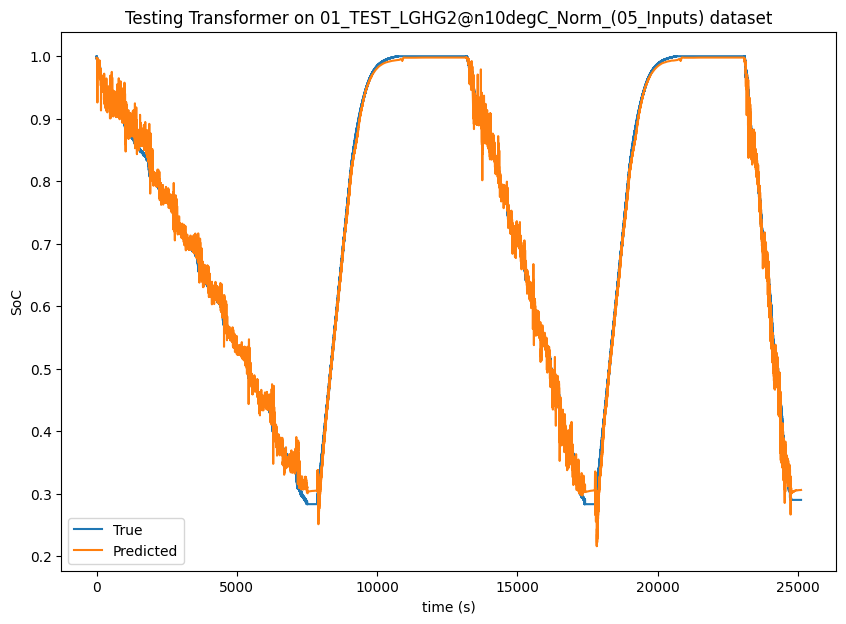


Testing on datasets/02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv
Test Loss: 0.00020204606739369696
(42466, 64, 1) (42466, 64, 1)
(2717824,) (2717824,)
MSE: 0.02%
RMSE: 1.42%
Max Error: 14.04%
MAE: 0.96%


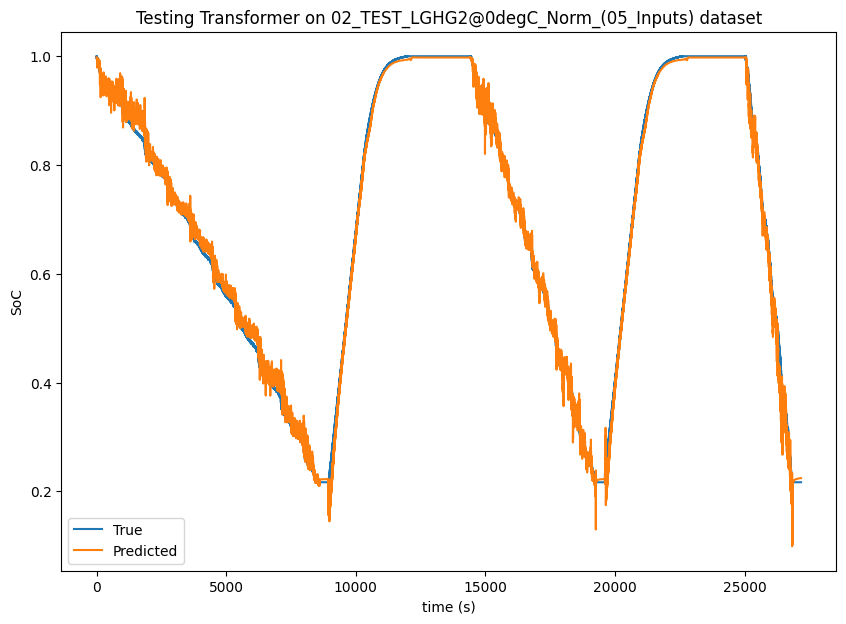


Testing on datasets/03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv
Test Loss: 0.00045585753155912793
(44220, 64, 1) (44220, 64, 1)
(2830080,) (2830080,)
MSE: 0.05%
RMSE: 2.13%
Max Error: 23.00%
MAE: 1.23%


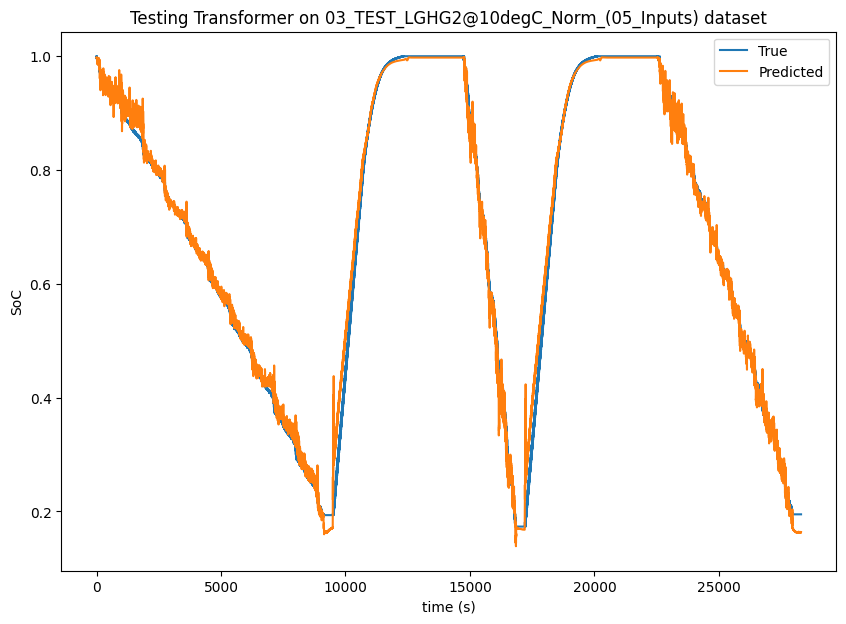


Testing on datasets/04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv
Test Loss: 0.00010873903910654515
(47453, 64, 1) (47453, 64, 1)
(3036992,) (3036992,)
MSE: 0.01%
RMSE: 1.04%
Max Error: 10.44%
MAE: 0.77%


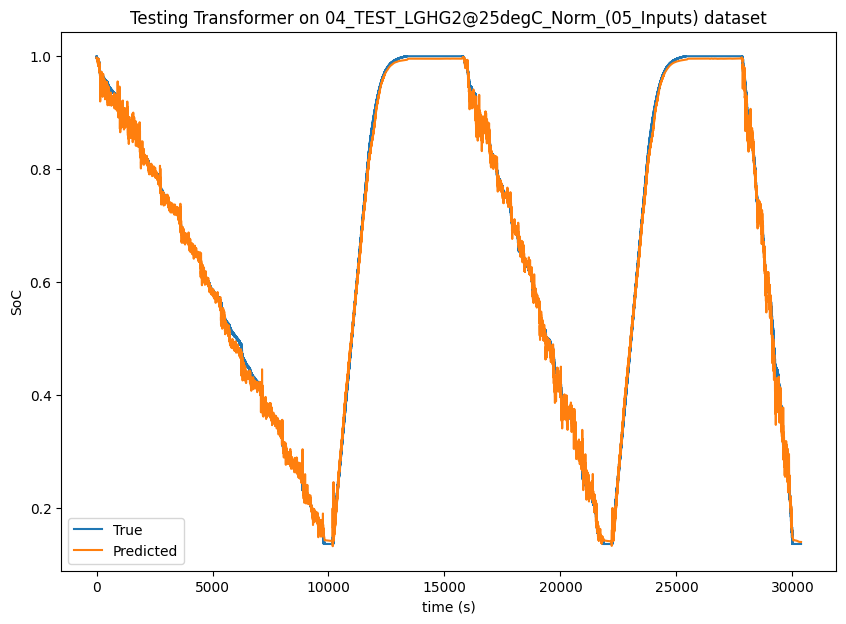

In [23]:
# Loading the model best trained parameters from checkpoint.pt
model.load_state_dict(torch.load('checkpoint.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# testing the model
test_model(
    model,
    test_datasets=['datasets/01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv',
                    'datasets/02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv',
                    'datasets/03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', 
                    'datasets/04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv'
                ],
    seq_len=64,
    model_name='Transformer'
)

In [25]:
test_data = SequentialLGDataset(
    path='datasets/UDDS_25degC_NO_C_Offset.csv',
    sequence_length=64,
)

testloader = get_dataloader(test_data, batch_size=128, shuffle=False)

In [26]:
# load the best model
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
test_loss = 0
y = []
y_pred = []
for i, (volt, current, dec_volt, dec_current, target) in enumerate(testloader):
    loss = model.validation_step(current, volt, dec_current, dec_volt, target)
    test_loss += loss
    y.append(target)
    y_pred.append(model(current.to(device), volt.to(device), dec_current.to(device), dec_volt.to(device)).cpu().detach())

test_loss /= len(testloader)
print(f'Test Loss: {test_loss}')

y = torch.cat(y, dim=0).numpy()
y_pred = torch.cat(y_pred, dim=0).numpy()
print(y.shape, y_pred.shape)

# unroll the sequence
y = y.reshape(-1)
y_pred = y_pred.reshape(-1)
print(y.shape, y_pred.shape)

Test Loss: 0.00010144413799935137
(15900, 64, 1) (15900, 64, 1)
(1017600,) (1017600,)


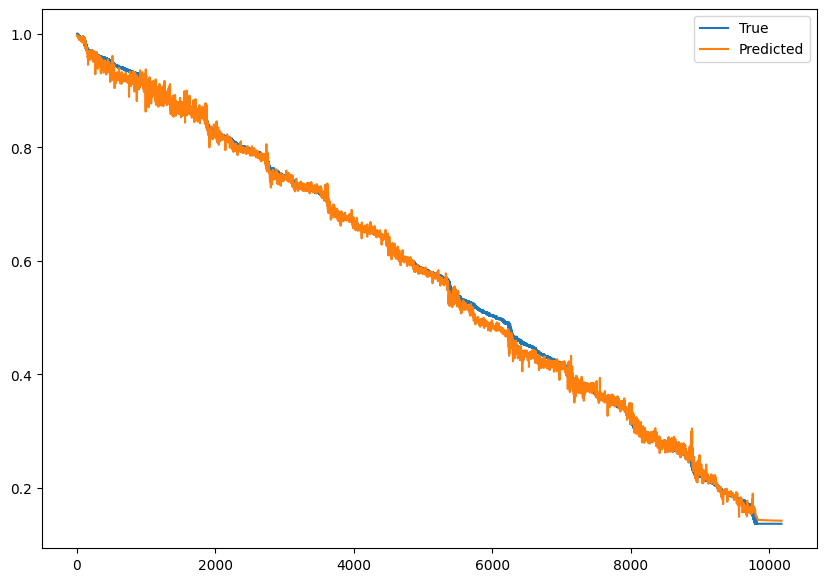

In [28]:
# plot the results
sampling = 100
plt.figure(figsize=(10, 7))
plt.plot(y[::sampling], label='True')
plt.plot(y_pred[::sampling], label='Predicted')

plt.legend()
plt.show()

In [29]:
mse = np.mean((y-y_pred)**2)
print(f'MSE: {mse*100:.2f}%')

rmse = np.sqrt(np.mean((y - y_pred)**2))
print(f'RMSE: {rmse*100:.2f}%')

maxx = np.max(np.abs(y-y_pred))
print(f'Max Error: {maxx*100:.2f}%')

mae = np.mean(np.abs(y-y_pred))
print(f'MAE: {mae*100:.2f}%')

MSE: 0.01%
RMSE: 1.01%
Max Error: 8.54%
MAE: 0.76%


#### Test with Noised current from LG-Dataset

In [ ]:
import os

model.load_state_dict(torch.load('checkpoint.pt'))
model = model.cuda()

files = [
    'LA92_n10degC_0p1_C_Offset.csv',
    'LA92_n10degC_0p3_C_Offset.csv',
    'LA92_n10degC_n0p1_C_Offset.csv',
    'LA92_n10degC_n0p3_C_Offset.csv',
    'LA92_n10degC_NO_C_Offset.csv'   
]

files = [os.path.join('datasets', file) for file in files]
test_model(
    model,
    test_datasets=files,
    seq_len=64,
    model_name='Transformer'
)


Testing on datasets\LA92_n10degC_0p1_C_Offset.csv
